In [1]:
import torch
import torchaudio
import torchaudio.functional as F

print(torch.__version__)
print(torchaudio.__version__)

2.1.0.dev20230423+cu117
2.1.0.dev20230423+cu117


In [2]:
# !pip3 install mir_eval
# !pip3 install pesq
# !pip3 install pystoi
from pesq import pesq
from pystoi import stoi
import mir_eval

import matplotlib.pyplot as plt
from IPython.display import Audio
from torchaudio.utils import download_asset

In [3]:
SAMPLE_RATE = 16000
SAMPLE_CLEAN = download_asset("tutorial-assets/mvdr/clean_speech.wav")
SAMPLE_NOISE = download_asset("tutorial-assets/mvdr/noise.wav")

https://dsp.stackexchange.com/questions/42517/gaussian-noise-generation-for-a-given-snr#:~:text=If%20you%20were%20given%20the%20SNR%20in%20decibels,could%20just%20add%20the%20noise%20to%20the%20signal.

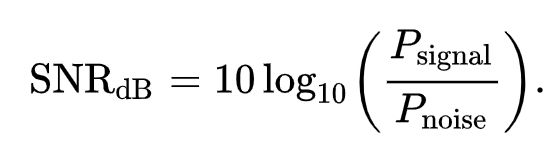

In [4]:
def plot_spectrogram(stft, title="Spectrogram", xlim=None):
    magnitude = stft.abs()
    spectrogram = 20 * torch.log10(magnitude + 1e-8).numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(spectrogram, cmap="viridis", vmin=-100, vmax=0, origin="lower", aspect="auto")
    figure.suptitle(title)
    plt.colorbar(img, ax=axis)
    plt.show()


def plot_mask(mask, title="Mask", xlim=None):
    mask = mask.numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(mask, cmap="viridis", origin="lower", aspect="auto")
    figure.suptitle(title)
    plt.colorbar(img, ax=axis)
    plt.show()


def si_snr(estimate, reference, epsilon=1e-8):
    estimate = estimate - estimate.mean()
    reference = reference - reference.mean()
    reference_pow = reference.pow(2).mean(axis=1, keepdim=True)
    mix_pow = (estimate * reference).mean(axis=1, keepdim=True)
    scale = mix_pow / (reference_pow + epsilon)

    reference = scale * reference
    error = estimate - reference

    reference_pow = reference.pow(2)
    error_pow = error.pow(2)

    reference_pow = reference_pow.mean(axis=1)
    error_pow = error_pow.mean(axis=1)

    si_snr = 10 * torch.log10(reference_pow) - 10 * torch.log10(error_pow)
    return si_snr.item()




def generate_mixture(waveform_clean, waveform_noise, target_snr):
    
    power_clean_signal = waveform_clean.pow(2).mean()
    power_noise_signal = waveform_noise.pow(2).mean()
    current_snr = 10 * torch.log10(power_clean_signal / power_noise_signal)
    
    waveform_noise *= 10 ** (-(target_snr - current_snr) / 20)
    return waveform_clean + waveform_noise


def evaluate(estimate, reference):
    si_snr_score = si_snr(estimate, reference)
    (
        sdr,
        _,
        _,
        _,
    ) = mir_eval.separation.bss_eval_sources(reference.numpy(), estimate.numpy(), False)
    pesq_mix = pesq(SAMPLE_RATE, estimate[0].numpy(), reference[0].numpy(), "wb")
    stoi_mix = stoi(reference[0].numpy(), estimate[0].numpy(), SAMPLE_RATE, extended=False)
    print(f"SDR score: {sdr[0]}")
    print(f"Si-SNR score: {si_snr_score}")
    print(f"PESQ score: {pesq_mix}")
    print(f"STOI score: {stoi_mix}")

In [5]:
waveform_clean, sr = torchaudio.load(SAMPLE_CLEAN)
waveform_noise, sr2 = torchaudio.load(SAMPLE_NOISE)
assert sr == sr2 == SAMPLE_RATE
# The mixture waveform is a combination of clean and noise waveforms with a desired SNR.
target_snr = 3
waveform_mix = generate_mixture(waveform_clean, waveform_noise, target_snr)

In [6]:
from scipy.io import wavfile
import noisereduce as nr
# load data
wav_noisy = "/media/public/datasets/denoising/DS_10283_2791/noisy_trainset_56spk_wav/p312_002.wav"

data, rate = torchaudio.load(wav_noisy)
# perform noise reduction
reduced_noise = torch.Tensor(nr.reduce_noise(y=data, sr=rate))
# wavfile.write("mywav_reduced_noise.wav", rate, reduced_noise)

In [7]:
Audio(data, rate=rate)

In [8]:
Audio(reduced_noise, rate=rate)

In [4]:
import sys
import os

from re import M
import uuid
import shutil
import ffmpeg
import logging
import gradio as gr


from denoisers.SpectralGating import SpectralGating

model = SpectralGating()


def denoising_transform(audio):
    src_path = "cache_wav/source/{}.wav".format(str(uuid.uuid4()))
    tgt_path = "cache_wav/target/{}.wav".format(str(uuid.uuid4()))
    # os.rename(audio.name, src_path)
    (ffmpeg.input(audio)
            .output(src_path, acodec='pcm_s16le', ac=1, ar=22050)
            .run()
    )
    
    model.predict(src_path, tgt_path)
    return tgt_path


inputs = gr.inputs.Audio(label="Source Audio", source="microphone", type='filepath')
outputs = gr.outputs.Audio(label="Target Audio", type='filepath')

title = "Chinese-to-English Direct Speech-to-Speech Translation (BETA)"
#"""
gr.Interface(
    denoising_transform, inputs, outputs, title=title,
    allow_flagging='never',
).launch(
    server_name='0.0.0.0',
    server_port=7871,
    # ssl_keyfile='../certificates/example.key',
    # ssl_certfile="../certificates/example.crt",
)

/home/maksim/miniconda3/envs/denoising/lib/python3.8/site-packages/gradio/inputs.py:319: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/home/maksim/miniconda3/envs/denoising/lib/python3.8/site-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/home/maksim/miniconda3/envs/denoising/lib/python3.8/site-packages/gradio/outputs.py:81: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(


Running on local URL:  http://0.0.0.0:7871

To create a public link, set `share=True` in `launch()`.


In [5]:
import gradio as gr

def greet(name):
    return "Hello " + name + "!"

demo = gr.Interface(fn=greet, inputs="text", outputs="text")

demo.launch() 

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [10]:
from metrics import evaluate

evaluate(reduced_noise, data, sample_rate=16000)

SDR score: 10.468852363171575
Si-SNR score: 5.981040954589844
PESQ score: 1.103776216506958
STOI score: 0.7633759118541069


In [ ]:
display(Audio(waveform_clean[0], rate = sr))


In [56]:
display(Audio(waveform_clean, rate = sr))
display(Audio(waveform_noise, rate = sr2))
display(Audio(waveform_mix, rate = sr))


In [57]:
waveform_mix = waveform_mix.to(torch.double)
waveform_clean = waveform_clean.to(torch.double)
waveform_noise = waveform_noise.to(torch.double)

In [58]:
N_FFT = 1024
N_HOP = 256
stft = torchaudio.transforms.Spectrogram(
    n_fft=N_FFT,
    hop_length=N_HOP,
    power=None,
)
istft = torchaudio.transforms.InverseSpectrogram(n_fft=N_FFT, hop_length=N_HOP)

stft_mix = stft(waveform_mix)
stft_clean = stft(waveform_clean)
stft_noise = stft(waveform_noise)


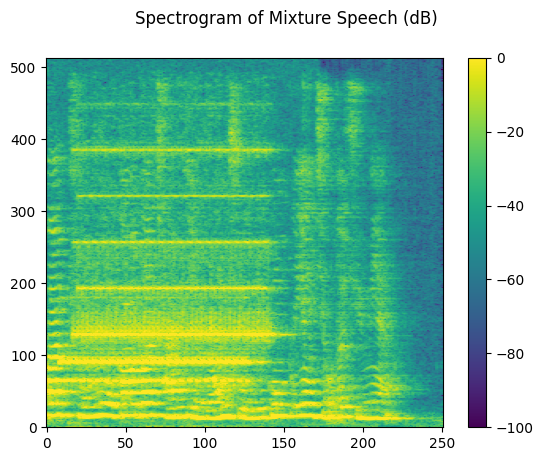

SDR score: 4.1403621817780305
Si-SNR score: 4.104058905536078
PESQ score: 2.0084526538848877
STOI score: 0.7724339398714715


In [59]:
plot_spectrogram(stft_mix[0], "Spectrogram of Mixture Speech (dB)")
evaluate(waveform_mix[0:1], waveform_clean[0:1])
Audio(waveform_mix[0], rate=SAMPLE_RATE)

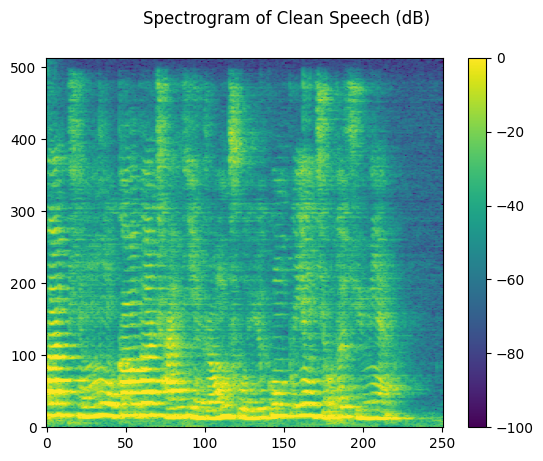

In [60]:
plot_spectrogram(stft_clean[0], "Spectrogram of Clean Speech (dB)")
Audio(waveform_clean[0], rate=SAMPLE_RATE)

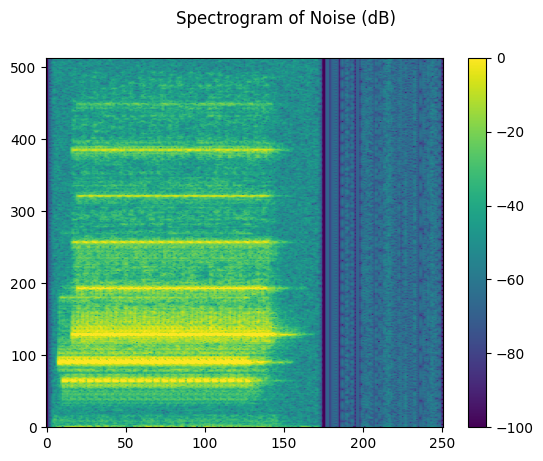

In [61]:
plot_spectrogram(stft_noise[0], "Spectrogram of Noise (dB)")
Audio(waveform_noise[0], rate=SAMPLE_RATE)

In [62]:
REFERENCE_CHANNEL = 0

https://www.ieda.ust.hk/dfaculty/so/pdf/SRI-Chen-et-al-2020.pdf

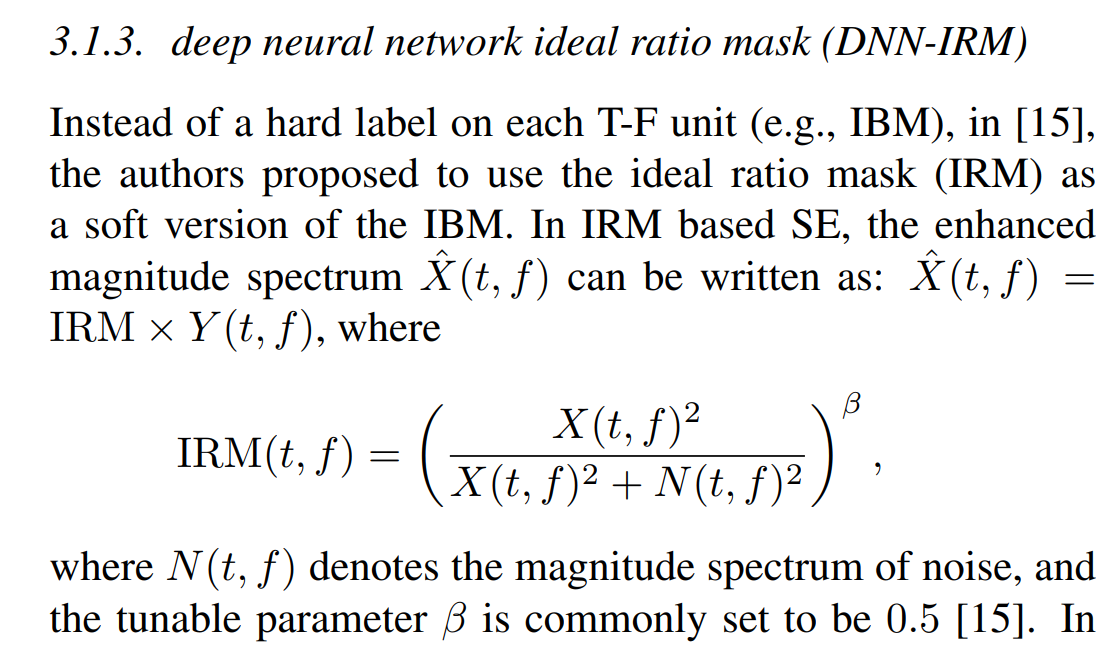

In [63]:
def get_irms(stft_clean, stft_noise):
    mag_clean = stft_clean.abs() ** 2
    mag_noise = stft_noise.abs() ** 2
    irm_speech = mag_clean / (mag_clean + mag_noise)
    irm_noise = mag_noise / (mag_clean + mag_noise)
    return irm_speech[REFERENCE_CHANNEL], irm_noise[REFERENCE_CHANNEL]


irm_speech, irm_noise = get_irms(stft_clean, stft_noise)

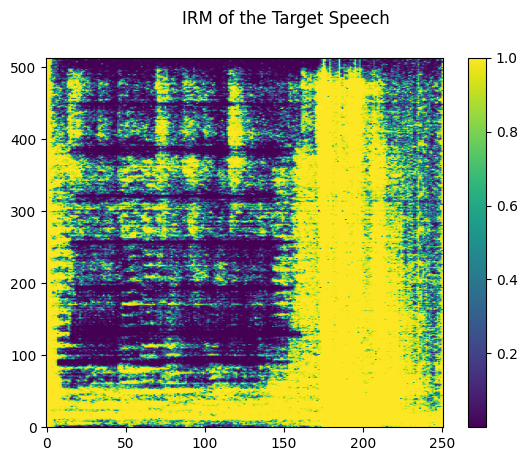

In [64]:
plot_mask(irm_speech, "IRM of the Target Speech")

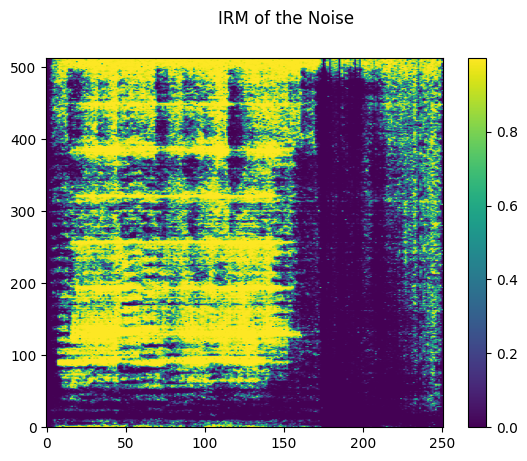

In [65]:
plot_mask(irm_noise, "IRM of the Noise")

In [67]:
psd_transform = torchaudio.transforms.PSD()

psd_speech = psd_transform(stft_mix, irm_speech)
psd_noise = psd_transform(stft_mix, irm_noise)

In [68]:
mvdr_transform = torchaudio.transforms.SoudenMVDR()
stft_souden = mvdr_transform(stft_mix, psd_speech, psd_noise, reference_channel=REFERENCE_CHANNEL)
waveform_souden = istft(stft_souden, length=waveform_mix.shape[-1])

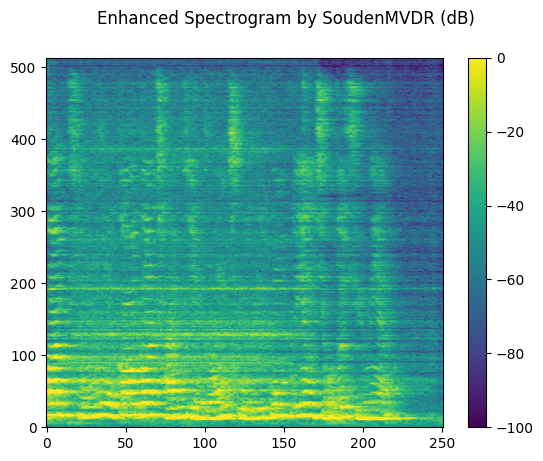

SDR score: 17.946234447508118
Si-SNR score: 12.215202612265614
PESQ score: 3.3447437286376953
STOI score: 0.8712864479161582


In [69]:
plot_spectrogram(stft_souden, "Enhanced Spectrogram by SoudenMVDR (dB)")
waveform_souden = waveform_souden.reshape(1, -1)
evaluate(waveform_souden, waveform_clean[0:1])
Audio(waveform_souden, rate=SAMPLE_RATE)

In [ ]:
def enhance_SoudenMDDR(wav):
    
    mvdr_transform = torchaudio.transforms.SoudenMVDR()
    stft_souden = mvdr_transform(stft_mix, psd_speech, psd_noise, reference_channel=REFERENCE_CHANNEL)
    waveform_souden = istft(stft_souden, length=waveform_mix.shape[-1])
    waveform_souden = waveform_souden.reshape(1, -1)
    evaluate(waveform_souden, waveform_clean[0:1])
    

# Enhanced Spectrogram by RTFMVDR

In [70]:
rtf_evd = F.rtf_evd(psd_speech)
rtf_power = F.rtf_power(psd_speech, psd_noise, reference_channel=REFERENCE_CHANNEL)

In [71]:
mvdr_transform = torchaudio.transforms.RTFMVDR()

# compute the enhanced speech based on F.rtf_evd
stft_rtf_evd = mvdr_transform(stft_mix, rtf_evd, psd_noise, reference_channel=REFERENCE_CHANNEL)
waveform_rtf_evd = istft(stft_rtf_evd, length=waveform_mix.shape[-1])

# compute the enhanced speech based on F.rtf_power
stft_rtf_power = mvdr_transform(stft_mix, rtf_power, psd_noise, reference_channel=REFERENCE_CHANNEL)
waveform_rtf_power = istft(stft_rtf_power, length=waveform_mix.shape[-1])

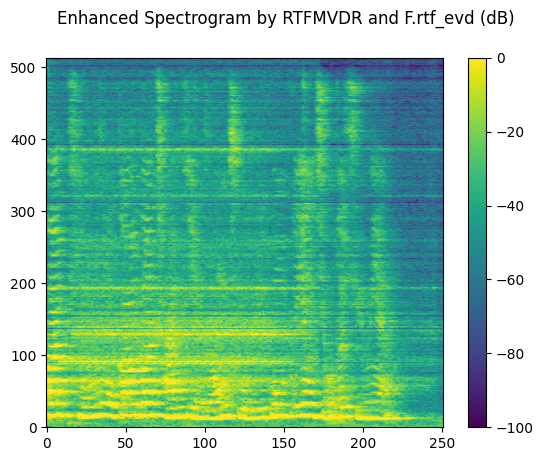

SDR score: 11.88021063528097
Si-SNR score: 10.7144199961281
PESQ score: 3.083890914916992
STOI score: 0.8261544910052993


In [72]:
plot_spectrogram(stft_rtf_evd, "Enhanced Spectrogram by RTFMVDR and F.rtf_evd (dB)")
waveform_rtf_evd = waveform_rtf_evd.reshape(1, -1)
evaluate(waveform_rtf_evd, waveform_clean[0:1])
Audio(waveform_rtf_evd, rate=SAMPLE_RATE)

# Enhanced Spectrogram by RTFMVDR and F.rtf_power

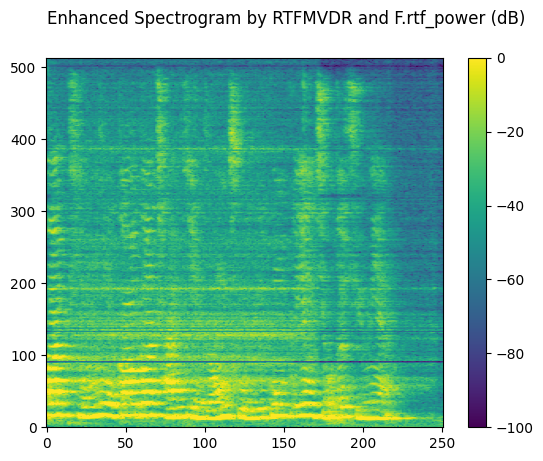

SDR score: 15.4245902769345
Si-SNR score: 13.035440892132868
PESQ score: 3.487997531890869
STOI score: 0.8798278461896505


In [73]:
plot_spectrogram(stft_rtf_power, "Enhanced Spectrogram by RTFMVDR and F.rtf_power (dB)")
waveform_rtf_power = waveform_rtf_power.reshape(1, -1)
evaluate(waveform_rtf_power, waveform_clean[0:1])
Audio(waveform_rtf_power, rate=SAMPLE_RATE)